# Implementing a reparameterized Beta sampler
@fritzo 2017-11-30

This notebook derives the `beta_grad(x,alpha,beta)` function that is used to compute reparameterized gradients in `torch.distributions.Beta().sample()`. This is an alternative to the naive stochastic reparameterized gradient estimator based on `Gamma().sample()` gradients.

In [22]:
import os
import torch
from torch.autograd import Variable
import itertools
import numbers
import numpy as np
import scipy.stats
import scipy.special
import scipy.optimize
from matplotlib import pyplot
from torch.distributions import Beta, Normal
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

In [2]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    np.random.seed(seed)

def expand_all(*args):
    zero = np.zeros(np.broadcast(*args).shape)
    return tuple(zero + arg for arg in args)

First, let's use SciPy to compute the desired reparameterized gradient for given (x, alpha,beta). This is based on the following definition. Let $x\sim Beta(\alpha,\beta)$ be a Beta random variable. The the reparameterized gradient wrt $\alpha$ is 
$$
 \frac {dx}{d\alpha} = -\frac{\frac d{d\alpha}cdf(x;\alpha)}
                             {\frac d{dx}cdf(x;\alpha)}
                     = -\frac{\frac d{d\alpha}cdf(x;\alpha)}{pdf(x;\alpha)}
$$

In [3]:
def dx_dalpha(x, alpha, beta):
    """
    Computes finite-difference approximation of the reparameterized gradient dx/dalpha.
    """
    cdf = scipy.stats.beta.cdf
    pdf = scipy.stats.beta.pdf
    eps = alpha * 0.02
    d_dalpha = (cdf(x, alpha + eps, beta) - cdf(x, alpha - eps, beta)) / (2 * eps)
    d_dx = pdf(x, alpha, beta)
    return -d_dalpha / d_dx

What this computes is the rate of change in x as alpha is varied and a horizontal line is fixed, cutting through cdf() values:

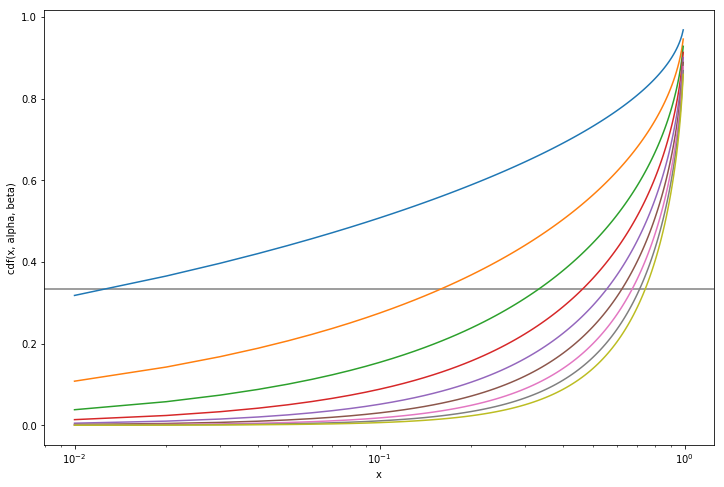

In [4]:
x = np.arange(0, 1, 0.01)
pyplot.figure(figsize=(12,8))
pyplot.axhline(0.333, color='gray')
beta = 0.5
for alpha in np.arange(0.2, 2, 0.2):
    pyplot.plot(x, scipy.stats.beta.cdf(x, alpha, beta))
pyplot.xscale('log')
pyplot.xlabel('x')
pyplot.ylabel('cdf(x, alpha, beta)')
pyplot.show()

In [5]:
digamma = scipy.special.digamma

def dx_dalpha_small(x, alpha, beta):
    return x / alpha * (1.0 / alpha + digamma(alpha) - digamma(alpha + beta) - np.log(x))
def dx_dbeta_small(x, alpha, beta):
    return x / alpha * (digamma(beta) - digamma(alpha + beta))
def dx_dalpha_small_valid(x, alpha, beta):
    return x * (1.0 + alpha + beta) < 0.1

def dx_dalpha_large(x, alpha, beta):
    # Equivalent to:
    # return -dx_dbeta_small(1.0 - x, beta, alpha)
    return (x - 1.0) / beta * (digamma(alpha) - digamma(alpha + beta))
def dx_dalpha_large_valid(x, alpha, beta):
    return 0.9 < x

def dx_dalpha_mid(x, alpha, beta):
    total = alpha + beta
    return ((total - 1) / total ** 2 +
            (x - alpha / total) * (0.5 / alpha - 1 / total - 0.5 / (1 + total)))
def dx_dalpha_mid_valid(x, alpha, beta):
    x, alpha, beta = expand_all(x, alpha, beta)
    return (alpha >= 10) & (beta >= 10)

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:400: RuntimeWarning: overflow encountered in exp
  return np.exp(self._logpdf(x, a, b))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


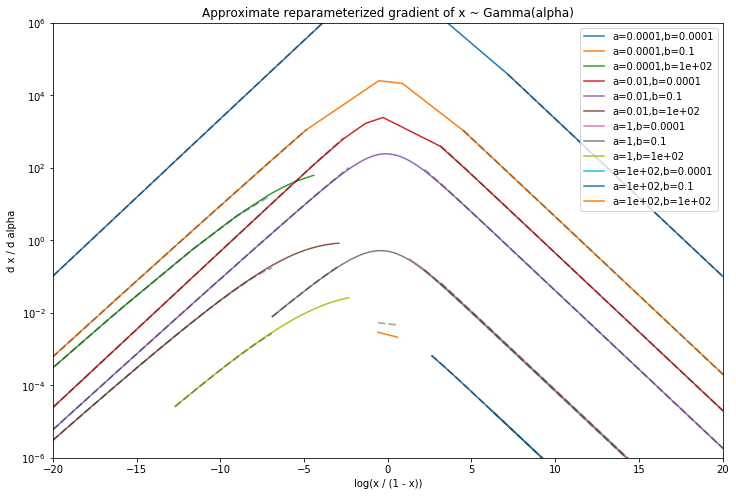

In [6]:
pyplot.figure(figsize=(12, 8))
for alpha, beta in itertools.product([1e-4, 1e-2, 1e0, 1e2], [1e-4, 1e-1, 1e2]):
    x = scipy.stats.beta.rvs(np.ones(10000) * alpha, np.ones(10000) * beta)
    x.sort()
    u = np.log(x / (1 - x))
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)),
                label='a={:0.1g},b={:0.1g}'.format(alpha, beta))
    w = dx_dalpha_small_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_small(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
    w = dx_dalpha_large_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_large(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
    w = dx_dalpha_mid_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_mid(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('log(x / (1 - x))')
pyplot.ylabel('d x / d alpha')
pyplot.yscale('log')
pyplot.xlim(-20, 20)
pyplot.ylim(1e-6, 1e6)
pyplot.legend()
pyplot.show()

Jumping ahead, let's see how our approximation works on randomly drawn samples for various `alpha` values between 0.0001 and 10000 (this uses the torch implementation):

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


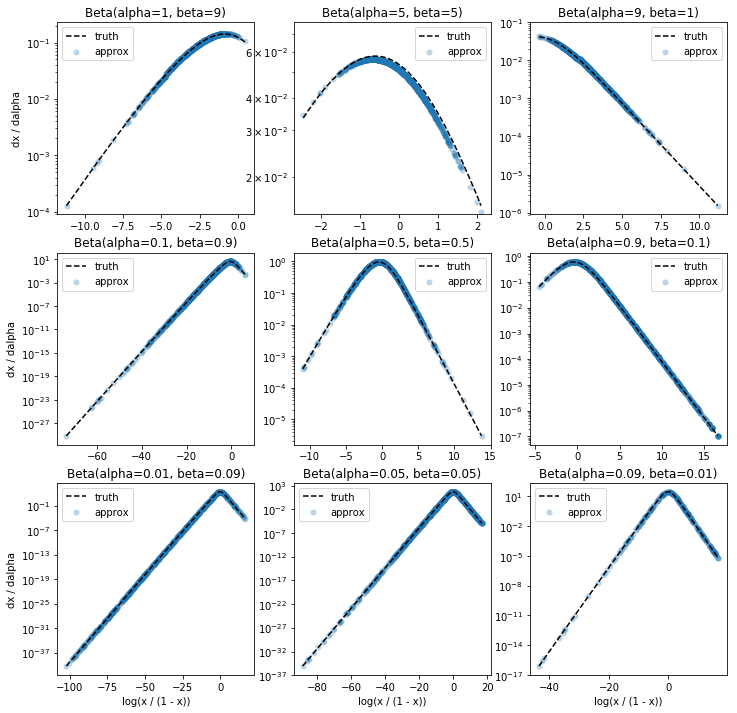

In [25]:
set_seed(0)
fig, axes = pyplot.subplots(3, 3, figsize=(12,12))
alpha_grid = [1.0, 5.0, 9.0, 0.1, 0.5, 0.9, 0.01, 0.05, 0.09]
beta_grid = [9.0, 5.0, 1.0, 0.9, 0.5, 0.1, 0.09, 0.05, 0.01]
ones = torch.ones(1000)
for i, (ax, alpha, beta) in enumerate(zip(axes.reshape(-1), alpha_grid, beta_grid)):
    alphas = Variable(alpha * ones, requires_grad=True)
    betas = Variable(beta * ones)
    x = Beta(alphas, betas).sample()
    x.sum().backward()
    x, ind = x.data.sort()
    x = x.numpy()
    u = np.log(x / (1 - x))
    actual_grad = alphas.grad.data[ind].numpy()
    ax.scatter(u, actual_grad, alpha=0.3, label='approx', lw=0)
    ax.plot(u, dx_dalpha(x, alpha, beta), 'k--', label='truth')
    ax.set_yscale('log')
    ax.set_title('Beta(alpha={:0.1g}, beta={:0.1g})'.format(alpha, beta))
    if i >= 6:
        ax.set_xlabel('log(x / (1 - x))')
    if i % 3 == 0:
        ax.set_ylabel('dx / dalpha')
    ax.legend()
pyplot.savefig(os.path.expanduser('~/Downloads/beta-reparameterized.png'))
pyplot.show()

## Benchmarks

And let's see how expensive the approximation is.

In [26]:
n = 10
dist = Beta(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
            Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.sample()
print('---- Backward ----')
%time x.sum().backward()

---- Forward ----
CPU times: user 1.26 s, sys: 57.9 ms, total: 1.32 s
Wall time: 1.32 s
---- Backward ----
CPU times: user 2.08 s, sys: 108 ms, total: 2.19 s
Wall time: 2.19 s


Here's a Normal distribution for comparison.

In [9]:
n = 10
dist = Normal(Variable(torch.ones(n, 1000, 1000), requires_grad=True),
              Variable(torch.ones(n, 1000, 1000), requires_grad=True))
print('---- Forward ----')
%time x = dist.sample()
# %time x = dist.sample(requires_grad=True)
# print('---- Backward ----')
# %time x.sum().backward()

---- Forward ----
CPU times: user 482 ms, sys: 36.6 ms, total: 519 ms
Wall time: 445 ms


## Approximating the reparameterized gradient

Now let's derive the approximation. Recall the shape of `cdf(x, alpha, beta)` that we want to approximate.

Let's approximate using a trivariate rational function of $\log(x/(1-x))$, $\log(\alpha)$, and $\log(\beta)$. We'll approximate using `cosh()` nonlinearity.

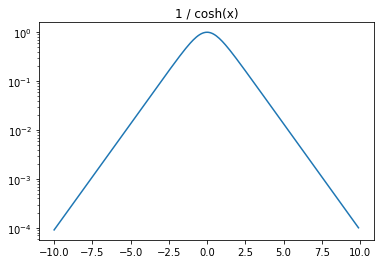

In [10]:
x = np.arange(-10, 10, 0.1)
pyplot.plot(x, 1.0 / np.cosh(x))
pyplot.yscale('log')
pyplot.title('1 / cosh(x)')
pyplot.show()

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in divide
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: i

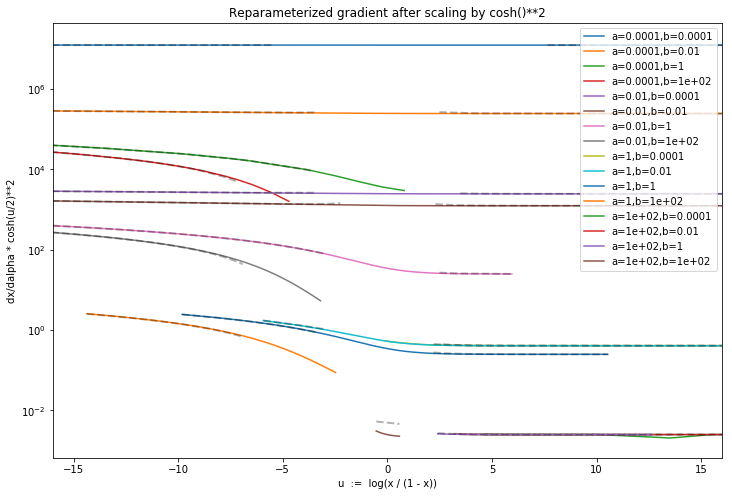

In [11]:
pyplot.figure(figsize=(12, 8))
for alpha, beta in itertools.product([1e-4, 1e-2, 1e0, 1e2], [1e-4, 1e-2, 1e0, 1e2]):
    x = scipy.stats.beta.rvs(np.ones(10000) * alpha, np.ones(10000) * beta)
    x.sort()
    u = np.log(x / (1 - x))
    g0 = np.cosh(0.5 * u) ** -2
    pyplot.plot(u, dx_dalpha(x, alpha, beta) / g0,
                label='a={:0.1g},b={:0.1g}'.format(alpha, beta))
    w = dx_dalpha_small_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_small(x[w], alpha, beta) / g0[w], 'k--', lw=2, alpha=0.3)
    w = dx_dalpha_large_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_large(x[w], alpha, beta) / g0[w], 'k--', lw=2, alpha=0.3)
    w = dx_dalpha_mid_valid(x, alpha, beta)
    pyplot.plot(u[w], dx_dalpha_mid(x[w], alpha, beta), 'k--', lw=2, alpha=0.3)
pyplot.title('Reparameterized gradient after scaling by cosh()**2')
pyplot.xlabel('u  :=  log(x / (1 - x))')
pyplot.ylabel('dx/dalpha * cosh(u/2)**2')
pyplot.yscale('log')
pyplot.xlim(-16, 16)
pyplot.legend()
pyplot.show()

This suggests a polynomial approximation of the center of the plot.

In [12]:
order = (4, 4, 4)
K = order[0] * order[1] * order[2]  # number of training parameters
def dx_dalpha_approx(x, alpha, beta, coef):
    x, alpha, beta = expand_all(x, alpha, beta)
    coef = coef.reshape(order)
    u = np.log(x / (1.0 - x))
    a = np.log(alpha)
    b = np.log(alpha + beta)
    us = [1.0, u, u * u, u * u * u]
    As = [1.0, a, a * a, a * a * a, a * a * a * a]
    bs = [1.0, b, b * b, b * b * b, b * b * b * b]
    poly = 0.0
    for i in range(order[0]):
        for j in range(order[1]):
            for k in range(order[2]):
                poly += coef[i][j][k] * us[i] * As[j] * bs[k]
    baseline = np.cosh(0.5 * u)
    return np.exp(poly) / (baseline * baseline)

### Constructing training data

We construct a stratified training set to balance the non-asymptotic data points among all $(\alpha,\beta)$ pairs.

In [13]:
np.random.seed(0)
size_train = 5000
LB, UB, grid_size = 1e-4, 1e2, 8
grid = LB * (UB / LB) ** (np.array(range(grid_size)) / (grid_size - 1.0))
alpha_bins, beta_bins, x_bins = [], [], []
bin_size = size_train / len(grid) ** 2
for alpha, beta in itertools.product(grid, grid):
    alpha_train = alpha * np.ones(100 * size_train)
    beta_train = beta * np.ones(100 * size_train)
    x_train = scipy.stats.beta.rvs(alpha_train, beta_train)
    valid = ~(dx_dalpha_small_valid(x_train, alpha_train, beta_train) |
              dx_dalpha_large_valid(x_train, alpha_train, beta_train))
    valid = valid.nonzero()[0]
    valid = valid[:bin_size]
    if len(valid) < bin_size:
        print('Warning: only {}/{} samples collected for alpha={:0.2g}, beta={:0.2g}'.format(
        len(valid), bin_size, alpha, beta))
    alpha_bins.append(alpha_train[valid])
    beta_bins.append(beta_train[valid])
    x_bins.append(x_train[valid])

alpha_train = np.concatenate(alpha_bins)
beta_train = np.concatenate(beta_bins)
x_train = np.concatenate(x_bins)
grad_train = dx_dalpha(x_train, alpha_train, beta_train)
print('Data size = {}'.format(len(grad_train)))

Data size = 4483


In [14]:
def approx_objective(coeff):
    approx = dx_dalpha_approx(x_train, alpha_train, beta_train, coeff).reshape(-1)
    return 1 - approx / grad_train

We'll warm start higher-order solutions with a low-order solution.

In [15]:
coef0 = np.zeros(K)
coef334 = np.array([
    -0.60053029913038736, -0.67617563662852986, 0.033289391601750568, -0.0055232783936459166,
    -0.75941091691009788, 0.044471911290455385, 0.0053838073297070984, -0.00047044737646155293,
    0.040206893001412003, -0.00031460537119546014, -0.00074685208106670912, 3.7911037859487209e-05,
    0.002107038501492289, -0.00037698371481752668, -0.00014084844217958958, 5.7160086113526577e-07,
    -0.14776487446458461, -0.069132247723632828, -0.016608476121648695, 0.0029528662921911122,
    0.027221814929254486, 0.019624842943435854, -0.0036339308700070005, 0.00041609833967909545,
    2.0368250450984454e-05, 0.0021596370600809839, -0.00051112075675257575, -1.5310177798121168e-07,
    -0.00025852024428467223, -1.2120293249073186e-05, -3.1670829591206352e-05, -1.5261990253173263e-06,
    0.022796316568323323, 0.011816619584157036, -0.011096906289936124, 0.0015584938162285071,
    -0.0065704050127365207, 0.013915930004686395, -0.0041164112478186089, 0.00038323328614432646,
    -0.0029764159890977048, 0.0030127357775451297, -0.00054195249925912347, 1.2310126862514687e-05,
    -0.00025888480523326356, 0.00017524793047137468, -2.2794740987602964e-05, -1.0207706178519581e-06,
]).reshape((3, 4, 4))
if order[0] >= 3 and order[1] >= 4 and order[2] >= 4:
    coef0.reshape(order)[:3, :4, :4] = coef334

In [16]:
soln = scipy.optimize.least_squares(approx_objective, coef0,
                                    xtol=1e-20, ftol=1e-20, gtol=1e-20)
coef = soln.x
print(soln)
print('coeff = {}'.format(list(coef)))
error = approx_objective(coef)
print('error = {:0.3g} rms, {:0.3g} max'.format(
    (error ** 2).mean() ** 0.5, np.abs(error).max()))

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`ftol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`xtol`", EPS))
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/scipy/optimize/_lsq/least_squares.py:117: UserWarning: `gtol` is too low, setting to machine epsilon 2.22044604925e-16.
  warn(message.format("`gtol`", EPS))


 active_mask: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
        cost: 1.7155030196352967
         fun: array([-0.01134877,  0.00091588,  0.01428549, ..., -0.00787689,
        0.00489278,  0.0351228 ])
        grad: array([  1.72192628e-02,  -3.71323889e-01,   1.12734608e+00,
        -1.16768094e+01,   9.88935768e-01,   4.23035762e+00,
         3.34912092e+00,   8.53454752e+01,  -2.77133202e+00,
        -3.61885462e+00,   2.38593880e+01,  -1.28535049e+02,
         3.52070864e+01,   1.43733768e+00,   1.77909536e+02,
        -2.10767117e+01,   9.05174258e-01,   1.80516843e+00,
         1.46122953e+01,  -2.36522443e+00,  -2.47526292e+00,
         1.72477990e+00,  -4.04080022e+01,  

Here's a per-region version that's closer our C implementation:

In [17]:
def dx_dalpha_final(x, alpha, beta):
    x, alpha, beta = expand_all(x, alpha, beta)
    result = dx_dalpha_approx(x, alpha, beta, coef)
    w = dx_dalpha_small_valid(x, alpha, beta)
    result[w] = dx_dalpha_small(x[w], alpha[w], beta[w])
    w = dx_dalpha_large_valid(x, alpha, beta)
    result[w] = dx_dalpha_large(x[w], alpha[w], beta[w])
    return result

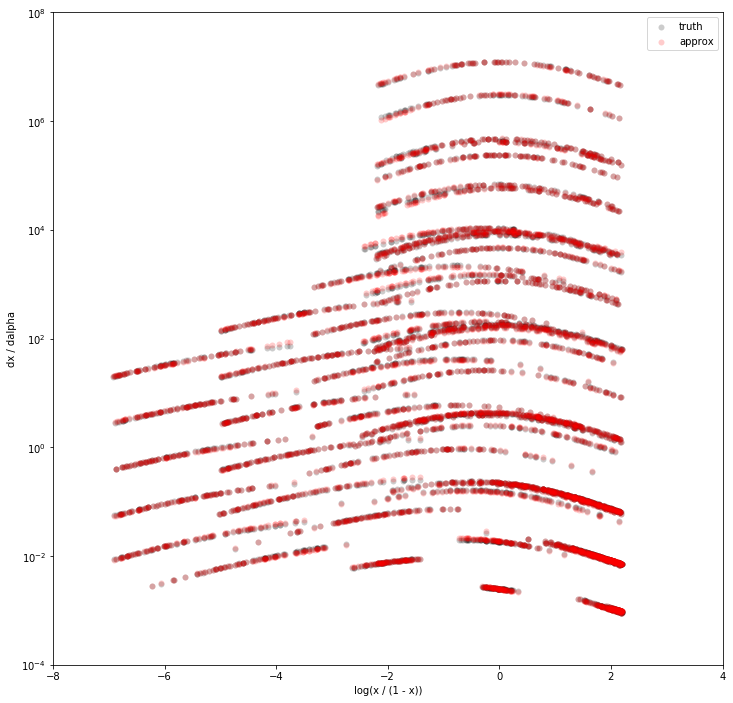

In [18]:
grad_approx = dx_dalpha_final(x_train, alpha_train, beta_train)
u = np.log(x_train / (1 - x_train))
pyplot.figure(figsize=(12, 12))
pyplot.scatter(u, grad_train, color='black', lw=0, alpha=0.2, label='truth')
pyplot.scatter(u, grad_approx, color='red', lw=0, alpha=0.2, label='approx')
pyplot.xlabel('log(x / (1 - x))')
pyplot.ylabel('dx / dalpha')
pyplot.yscale('log')
pyplot.xlim(-8, 4)
pyplot.ylim(1e-4, 1e8)
pyplot.legend()
pyplot.show()

/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in add
  app.launch_new_instance()
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/fritzobermeyer/miniconda2/envs/pytorch-dev/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
 

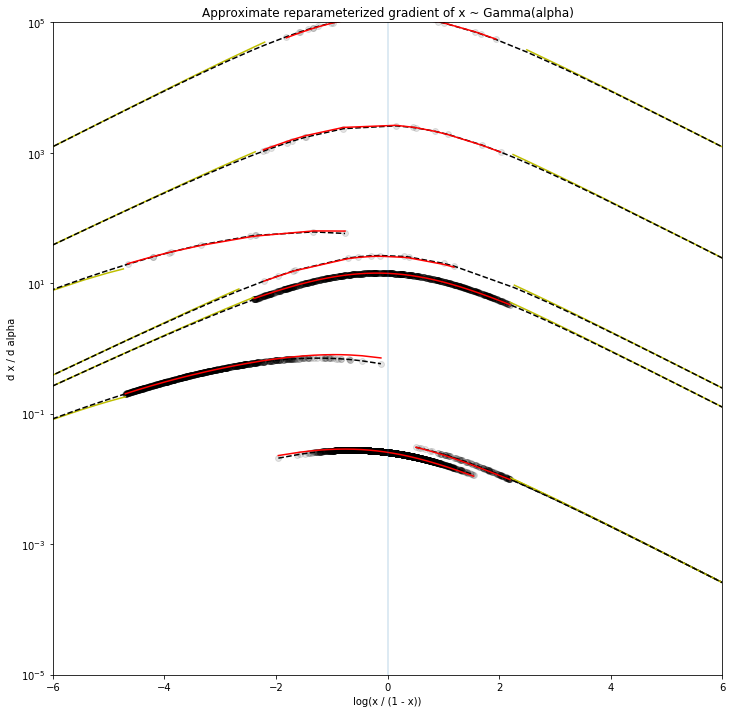

In [19]:
pyplot.figure(figsize=(12, 12))
ones = np.ones(5000)
for alpha, beta in itertools.product([1e-3, 1e-1, 1e1], [1e-3, 1e-1, 1e1]):
    x = scipy.stats.beta.rvs(ones * alpha, ones * beta)
    x.sort()
    u = np.log(x / (1 - x))
    w1 = dx_dalpha_small_valid(x, alpha, beta)
    w2 = dx_dalpha_large_valid(x, alpha, beta)
    w = ~(w1 | w2)
    pyplot.plot(u[w1], np.maximum(1e-20, dx_dalpha_final(x[w1], alpha, beta)), 'y-')
    pyplot.plot(u[w2], np.maximum(1e-20, dx_dalpha_final(x[w2], alpha, beta)), 'y-')
    pyplot.scatter(u[w], np.maximum(1e-20, dx_dalpha(x[w], alpha, beta)),
                   color='black', alpha=0.1)
    pyplot.plot(u, np.maximum(1e-20, dx_dalpha(x, alpha, beta)), 'k--')
    pyplot.plot(u[w], np.maximum(1e-20, dx_dalpha_final(x[w], alpha, beta)), 'r-')
pyplot.axvline(0, alpha=0.2)
pyplot.title('Approximate reparameterized gradient of x ~ Gamma(alpha)')
pyplot.xlabel('log(x / (1 - x))')
pyplot.ylabel('d x / d alpha')
pyplot.yscale('log')
pyplot.xlim(-6, 6)
pyplot.ylim(1e-5, 1e5)
pyplot.legend()
pyplot.show()

Finally, let's print out C code for the coefficients and embed this directly in `aten/src/TH/THRandom.c`.

In [20]:
print('static const double coef[{}][{}][{}] = {{{{'.format(*order))
for i, block in enumerate(coef.reshape(order)):
    if i:
        print('  }, {')
    for row in block:
        print('    {' + ', '.join(map('{:0.8g}'.format, row)) + '},')
print('}};')

static const double coef[4][4][4] = {{
    {-0.59670494, -0.67549997, 0.015855541, 0.00066922352},
    {-0.75465802, 0.06350534, -0.0073161272, 0.00019942935},
    {0.039820428, 0.0064008513, -0.0019702682, 3.5305578e-05},
    {0.002073895, 0.00014913092, -0.00014831525, -1.5144627e-07},
  }, {
    {-0.15841663, -0.075230931, -0.003620898, 0.0041526655},
    {0.025639107, 0.0012249959, -0.0037795784, 0.00048903979},
    {0.0024039508, 0.00010430419, -0.00056361722, 1.0134615e-05},
    {2.0032581e-05, -4.0230223e-05, -2.328269e-05, -1.3205537e-08},
  }, {
    {0.023160419, 0.015633698, -0.001210893, 0.00038910122},
    {-0.0093390756, 0.0030599691, -0.0012448356, 0.00017923358},
    {-0.0014138937, 0.0011084419, -0.00025173238, 6.2842575e-06},
    {-9.9747034e-05, 8.5914774e-05, -1.1276987e-05, -4.5394837e-07},
  }, {
    {0.003056811, 0.0022101196, 0.00028245712, -9.0866266e-05},
    {-0.00079572275, -0.00012345085, 0.00013419397, -1.4536178e-05},
    {6.0251988e-05, 2.9694109e-06, 1.1